In [257]:
import sys, os, glob
import numpy, scipy

path = "../work/run-scf-kpt"
assert os.path.exists(path)

# find all the out.log files
out_logs = glob.glob(os.path.join(path, "**", "out.log"), recursive=True)

def get_info_from_out_log(out_log):
    d = {}
    kmesh = out_log.split("/")[4]
    kmesh = [int(x) for x in kmesh.split("-")]
    d["kmesh"] = numpy.prod(kmesh)
    d["method"] = "-".join(out_log.split("/")[5].split("-")[:-1])
    d["ncpu"] = int(out_log.split("/")[5].split("-")[-1])
    d["cell"] = out_log.split("/")[3]
    d["natm"] = 2 if d["cell"] == "diamond-prim" else 8

    with open(out_log, "r") as f:
        table = []
        for line in f:
            if "CPU time" in line:
                key_word = line.split()[3]
                wall_time = line.split()[8]
                d["t_" + key_word] = float(wall_time)

            if "###" in line:
                table.append(line)

        assert len(table) == 2
        keys = table[0][3:].split(",")
        values = table[1][3:].split(",")
        for key, value in zip(keys, values):
            d[key.strip()] = float(value.strip())

    return d

data = []
# read the out.log files
for out_log in out_logs:
    d = get_info_from_out_log(out_log)
    data.append(d)



[ 20.  40.  60.  80. 100.] [ 5. 10. 15. 20.] [ 1  2  4  8 16 32 64]


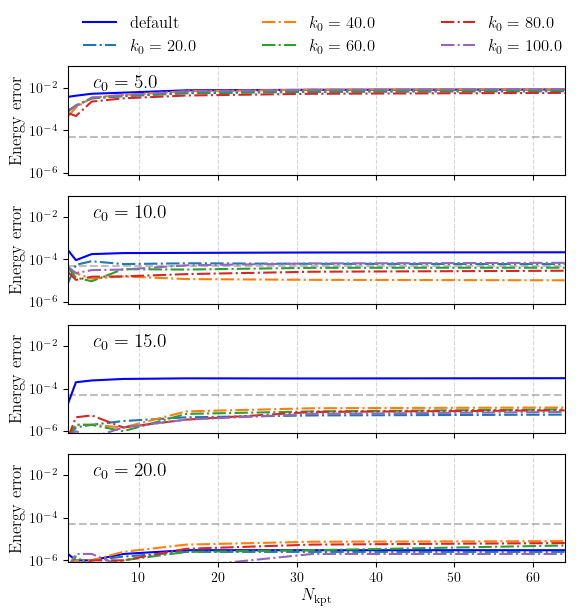

In [258]:
# plot all the data with kpts
import matplotlib.pyplot as plt
# use latex
plt.rcParams["text.usetex"] = True
# use latex font
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Computer Modern Roman"

# fig, ax = plt.subplots()

method = ["fftdf", "gdf", "fftisdf-jy"]

# for m in method:
#     x = [d["kmesh"] for d in data if d["method"] == m and d["ncpu"] == 1]
#     y = [d["t_build"] for d in data if d["method"] == m and d["ncpu"] == 1]

#     x = numpy.array(x)
#     y = numpy.array(y)
#     m = numpy.argsort(x)
#     x = x[m]
#     y = y[m]

#     print(x, y)

#     ax.plot(x, y, label=m)

# plot all the error
ks = []
cs = []
kmesh = []

for d in data:
    k0 = d.get("k0", None)
    c0 = d.get("c0", None)
    if k0 is not None and c0 is not None:
        ks.append(k0)
        cs.append(c0)
        kmesh.append(d["kmesh"])

ks = numpy.array(ks)
cs = numpy.array(cs)
kmesh = numpy.array(kmesh)

ks = numpy.unique(ks)
cs = numpy.unique(cs)
kmesh = numpy.unique(kmesh)

print(ks, cs, kmesh)

fig, axs = plt.subplots(len(cs), 1, figsize=(6, 6), sharex=True)

d0 = [d for d in data if d["method"] == "fftdf" and d["ncpu"] == 1]
d1 = [d for d in data if d["method"] == "fftisdf-jy" and d["ncpu"] == 1 and d.get("k0", None) is not None]
d2 = [d for d in data if d["method"] == "fftisdf-jy" and d["ncpu"] == 1 and d.get("k0", None) is None]

for i, c0 in enumerate(cs):
    ax = axs[i]
    ax.text(0.05, 0.80, f"$c_0 = {c0:.1f}$", transform=ax.transAxes, fontsize=14)
    ax.axhline(5e-5, color="grey", linestyle="--", alpha=0.5)
    ax.grid(True, which="major", alpha=0.5, linestyle="--", axis="x")

    x2 = [d["kmesh"] for d in d2 if d["c0"] == c0]
    y2 = [d["e_tot"] for d in d2 if d["c0"] == c0]
    x2 = numpy.array(x2)
    y2 = numpy.array(y2)
    m = numpy.argsort(x2)
    x2 = x2[m]
    y2 = y2[m]
    ax.semilogy(x2, abs(y0 - y2) + 1e-6, label=f"default", color="b", linestyle="-")
    for k0 in ks:
        x0 = [d["kmesh"] for d in d0]
        y0 = [d["e_tot"] for d in d0]
        x0 = numpy.array(x0)
        y0 = numpy.array(y0)
        m = numpy.argsort(x0)
        x0 = x0[m]
        y0 = y0[m]

        x1 = [d["kmesh"] for d in d1 if d["k0"] == k0 and d["c0"] == c0]
        y1 = [d["e_tot"] for d in d1 if d["k0"] == k0 and d["c0"] == c0]
        x1 = numpy.array(x1)
        y1 = numpy.array(y1)
        m = numpy.argsort(x1)
        x1 = x1[m]
        y1 = y1[m]

        xx = x0
        yy = abs(y0 - y1) + 1e-6
        natm = d0[0]["natm"]
        ax.semilogy(xx, yy / natm, label=f"$k_0={k0}$", linestyle="-.")
        
        ax.set_xlim(x0[0], x0[-1])
        ax.set_ylim(8e-7, 0.1)
        ax.set_yticks([1e-6, 1e-4, 1e-2])
        # ax.set_yticklabels(["1e-6", "1e-5", "1e-4", "1e-3", "1e-2"])

# put it to the top
# no box
axs[0].legend(
    loc="upper left",
    bbox_to_anchor=(0, 1.6),
    ncol=3, fontsize=12,
    frameon=False, columnspacing=4.0
)
fig.tight_layout()

axs[-1].set_xlabel(r"$N_{\mathrm{kpt}}$", fontsize=12)
for ax in axs:
    ax.set_ylabel("Energy error", fontsize=12)

plt.show()
        

In [259]:
dd = []
for d in data:
    if d["method"] == "fftisdf-jy" and d["ncpu"] == 1:
        k0 = d.get("k0", None)
        c0 = d.get("c0", None)
        if k0 == 40.0 and c0 == 10.0:
            dd.append(d)

for d1 in sorted(dd, key=lambda x: x["kmesh"]):
    kmesh = d1["kmesh"]
    t_build = d1["t_build"]
    t_vj = d1["t_vj"]
    t_vk = d1["t_vk"]

    e_ref = None
    for d2 in data:
        if d2["method"] == "fftdf" and d2["ncpu"] == 1 and d2["kmesh"] == kmesh:
            e_ref = d2["e_tot"]
            break

    assert e_ref is not None
    natm = d1["natm"]
    err = abs(e_ref - d1["e_tot"]) / natm
    print(f"{kmesh:4d} {t_build:6.2f} {t_vj:6.2f} {t_vk:6.2f} {err:6.2e}")
    assert err < 5e-5

dd = sorted(dd, key=lambda x: x["kmesh"])

   1   1.50   0.37   0.00 3.30e-05
   2   2.02   0.35   0.01 2.20e-05
   4   3.05   0.35   0.01 1.20e-05
   8   5.88   0.46   0.02 1.55e-05
  16  12.82   0.81   0.06 1.15e-05
  32  25.90   1.32   0.15 1.05e-05
  64  44.71   2.00   0.30 1.00e-05


In [260]:
df = []
for d in data:
    if d["method"] == "fftdf" and d["ncpu"] == 1:
        df.append(d)

df = sorted(df, key=lambda x: x["kmesh"])

dg = []
for d in data:
    if d["method"] == "gdf" and d["ncpu"] == 1:
        dg.append(d)

dg = sorted(dg, key=lambda x: x["kmesh"])



[1. 2. 3. 4. 5. 6. 7.] [1.5, 2.02, 3.05, 5.88, 12.82, 25.9, 44.71]


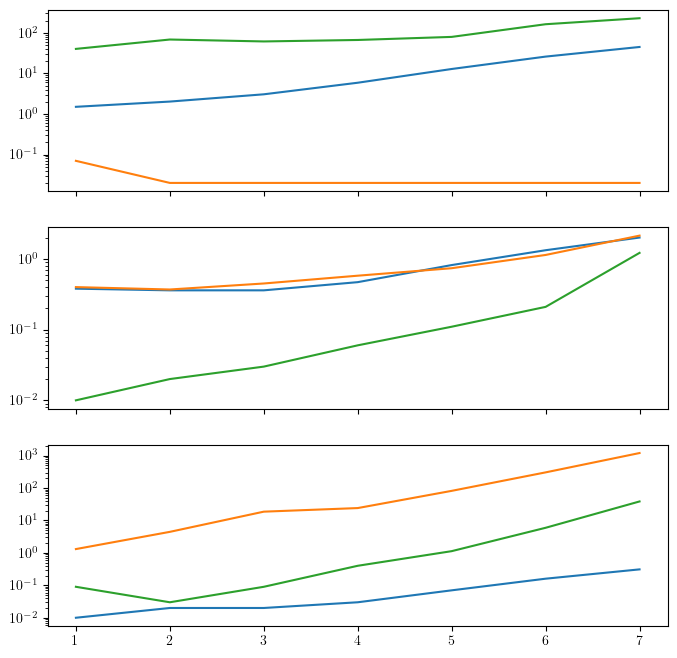

In [261]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

# plot the timing
ax = axs[0]
natm = dd[0]["natm"]
x = [d["kmesh"] * natm for d in dd]
x = numpy.log2(x)
y = [d["t_build"] for d in dd]
print(x, y)
ax.semilogy(x, y, label="fftisdf")

x = [d["kmesh"] * natm for d in df]
x = numpy.log2(x)
y = [d["t_build"] + 1e-2 for d in df]
ax.semilogy(x, y, label="fftdf")

x = [d["kmesh"] * natm for d in dg]
x = numpy.log2(x)
y = [d["t_build"] for d in dg]
ax.semilogy(x, y, label="gdf")

ax = axs[1]
x = [d["kmesh"] * natm for d in dd]
x = numpy.log2(x)
y = [d["t_vj"] + 1e-2 for d in dd]
ax.semilogy(x, y, label="fftisdf")

x = [d["kmesh"] * natm for d in df]
x = numpy.log2(x)
y = [d["t_vj"] + 1e-2 for d in df]
ax.semilogy(x, y, label="fftdf")

x = [d["kmesh"] * natm for d in dg]
x = numpy.log2(x)
y = [d["t_vj"] + 1e-2 for d in dg]
ax.semilogy(x, y, label="gdf")

ax = axs[2]
x = [d["kmesh"] * natm for d in dd]
x = numpy.log2(x)
y = [d["t_vk"] + 1e-2 for d in dd]
ax.semilogy(x, y, label="fftisdf")

x = [d["kmesh"] * natm for d in df]
x = numpy.log2(x)
y = [d["t_vk"] + 1e-2 for d in df]
ax.semilogy(x, y, label="fftdf")

x = [d["kmesh"] * natm for d in dg]
x = numpy.log2(x)
y = [d["t_vk"] + 1e-2 for d in dg]
ax.semilogy(x, y, label="gdf")

# ax.legend()